In [1]:
import sys 
import os
sys.path.append(os.path.join(os.path.split(sys.path[0])[0], 'src'))

import numpy as np
a = np.ones((2,2))
a@a
import matplotlib.pyplot as plt
import KPCA
from KPCA import compute_kernel_matrix
from utils import get_data, calc_energy

from sklearn.decomposition import KernelPCA

In [67]:
def reverse_combo(base, extra,combo, X, theta, eps_base = None, eps_extra = None, dx = 1, dy = None):
    K1 = compute_kernel_matrix(X, base.X_fit, base.kernel, theta, eps_base,dx,dy)
    K2 = compute_kernel_matrix(X, extra.X_fit, extra.kernel, theta, eps_extra,dx,dy)

    K = K1 * K2
    mean = combo.K_fit.mean(0)[None,:]
    Phi = (K - mean) @ combo.U_fit

    # sqrt_theta = np.sqrt(theta).T
    # ones_phi = np.ones((Phi.shape[0],1))
    # Phi_ext = np.concatenate([ones_phi] + [ones_phi / sqrt_theta] + [Phi**(k+1) for k in range(combo.degree)]+ [(Phi / sqrt_theta)**(k+1) for k in range(combo.degree)], axis=1)
    # #reconstruction
    # X = combo.R@Phi_ext.T
    return combo.invert_transform(Phi, theta)
    # return X

In [211]:
def GridSearch(base, extra, combo,X, params, gammas, kernel, kernel_base):
    if len(params) == 5:
        Re, Wi, beta, theta, dx = params
        eps = None
    elif len(params) == 6:
        Re, Wi, beta,eps, theta, dx = params
    base.fit(X.T,2,kernel_base,theta = theta,dx=dx, eps= eps)
    combo.fit(X.T,2,'oldroyd',theta = theta,dx=dx,)
    X_base = base.invert_transform(base.transform(X.T,theta, dx = dx, eps=eps), theta)
    _,_, total = calc_energy(X, Wi, beta, Re, dx)
    # _,_, energy_base = calc_energy(X_base, Wi, beta, Re, dx)
    err_extra = np.zeros(len(gammas))
    err_combo = np.zeros(len(gammas))
    for i,gamma in enumerate(gammas):

        extra.fit(X.T,2,kernel,theta = theta,dx=dx,eps=gamma)
        combo.K_fit = base.K_fit * extra.K_fit
        combo.train_R(n_components=2, recalc_eig = True)
        X_extra = extra.invert_transform(extra.transform(X.T,theta, eps = gamma, dx = dx), theta)
        X_combo = reverse_combo(base, extra, combo, X.T, theta = theta, dx = dx, eps_base = eps, eps_extra = gamma)

        
        _,_, energy_extra = calc_energy(X_extra, Wi, beta, Re, dx)
        _,_, energy_combo = calc_energy(X_combo, Wi, beta, Re, dx)

        err_extra[i] = np.sum(np.abs(energy_extra - total))/total.sum()
        err_combo[i] = np.sum(np.abs(energy_combo - total))/total.sum()
    return np.argsort(err_extra), np.argsort(err_combo),err_extra, err_combo

In [161]:
model_base = KPCA.KernelPCA()
model_oldroyd = KPCA.KernelPCA()
model_extra = KPCA.KernelPCA()
model_combo = KPCA.KernelPCA()
model_pca = KPCA.KernelPCA()

In [214]:
dx = 0.0125
Re = 1
Wi = 0.5
beta = 0.5
eps = .3
X, Xmean = get_data(Re, Wi, beta, case='ptt', eps = eps,n_data = -2,dir_path='../../npz_data', from_end=False)
theta =((1-beta)/(Re*Wi))
print('Theta: ', theta)

Theta:  1.0


In [215]:
gammas = np.linspace(1,20,20)
print(gammas)
params = (Re, Wi, beta,eps, theta, dx)

extra_ind, combo_ind, extra_err,combo_err = GridSearch(model_base, model_extra, model_combo, X, params, gammas, 'rbf', 'ptt')
print(f'Best Extra: {gammas[extra_ind[0]]}')
print(f'Best Combo: {gammas[combo_ind[0]]}')

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]
Best Extra: 6.0
Best Combo: 6.0


In [216]:
kernel = 'rbf'
kernel_base = 'ptt'
# gamma = (50, 2.5)
gamma =6

model_base.fit(X.T,2,kernel_base,theta = theta,dx=dx,eps=eps)
model_oldroyd.fit(X.T,2,'oldroyd',theta = theta,dx=dx,eps=eps)
model_pca.fit(X.T,2,'linear',theta = theta,dx=1,)
model_extra.fit(X.T,2,kernel,theta = theta,dx=1,eps=gamma)

model_combo.fit(X.T,2,kernel_base,theta = theta,dx=1,eps=eps)
model_combo.K_fit = model_base.K_fit * model_extra.K_fit
model_combo.train_R(n_components=2, recalc_eig=True)

In [217]:
X_base = model_base.invert_transform(model_base.transform(X.T,theta, dx = dx, eps=eps), theta)
X_oldroyd = model_oldroyd.invert_transform(model_oldroyd.transform(X.T,theta, dx = dx, eps=eps), theta)
X_extra = model_extra.invert_transform(model_extra.transform(X.T,theta,eps = gamma, dx = dx), theta)
X_combo = reverse_combo(model_base, model_extra, model_combo, X.T, theta = theta, dx = dx,  eps_base = eps, eps_extra = gamma,)
X_pca = model_pca.invert_transform(model_pca.transform(X.T,theta, 1), theta)

In [218]:

_,_, total = calc_energy(X, Wi, beta, Re, dx)
_,_, base = calc_energy(X_base, Wi, beta, Re, dx)
_,_, oldroyd = calc_energy(X_oldroyd, Wi, beta, Re, dx)
_,_, extra = calc_energy(X_extra, Wi, beta, Re, dx)
_,_, combo = calc_energy(X_combo, Wi, beta, Re, dx)
_,_, pca = calc_energy(X_pca, Wi, beta, Re, dx)

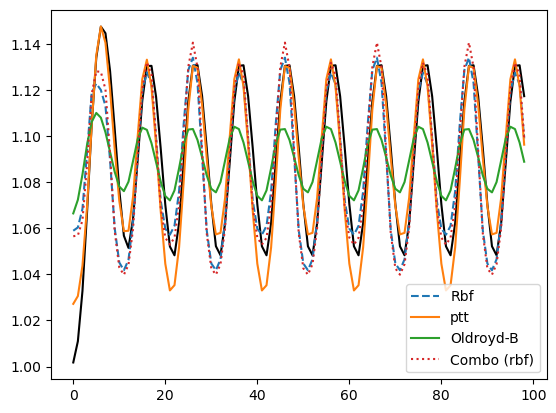

In [219]:

plt.plot(total,'k')
# plt.plot(pca, label = 'PCA')
plt.plot(extra,'--', label = f'{kernel.capitalize()}')
plt.plot(base, label = f'{kernel_base}')
plt.plot(oldroyd, label = f'Oldroyd-B')
plt.plot(combo,linestyle='dotted', label = f'Combo ({kernel})')

# plt.ylim(0.95,1.08)
plt.legend()

In [222]:
err_oldroyd = np.abs(total - base).sum() / total.sum()
err_extra = np.abs(total - extra).sum() / total.sum()
err_pca = np.abs(total - pca).sum() / total.sum()
err_combo = np.abs(total - combo).sum() / total.sum()

print(f'Error {kernel_base}: {err_oldroyd:g}')
print(f'Error {kernel.capitalize()}: {err_extra:g}')
print(f'Error PCA: {err_pca:g}')
print(f'Error Combo: {err_combo:g}')

Error ptt: 0.00876101
Error Rbf: 0.0131116
Error PCA: 0.0201728
Error Combo: 0.012234


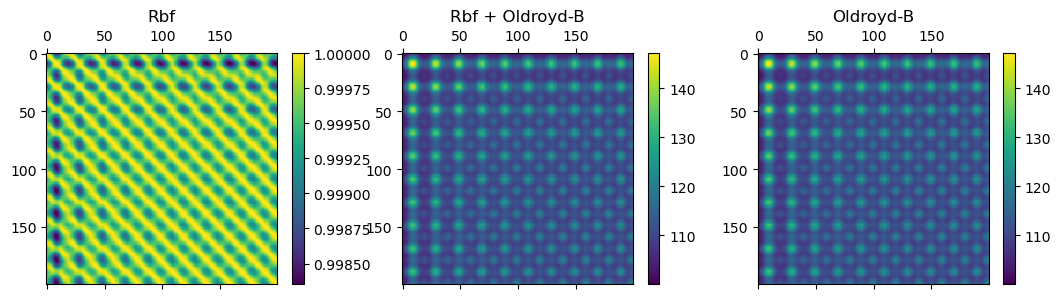

In [7]:
gamma = 1000
kernel = 'rbf'
model_base.fit(X.T,2,'oldroyd',theta = theta,dx=dx,)
model_pca.fit(X.T,2,'linear',theta = theta,dx=1,)
model_extra.fit(X.T,2,kernel,theta = theta,dx=1,eps=gamma)

model_combo.fit(X.T,2,'oldroyd',theta = theta,dx=1,)
model_combo.K_fit = model_base.K_fit * model_extra.K_fit
model_combo.train_R(n_components=2)

f, ax = plt.subplots(figsize=(13, 3), ncols=3)
s0 = ax[0].matshow(model_extra.K_fit)
s1 =ax[1].matshow(model_combo.K_fit)
s2 = ax[2].matshow(model_base.K_fit)


ax[0].set_title(f'{kernel.capitalize()}')
ax[1].set_title(f'{kernel.capitalize()} + Oldroyd-B')
ax[2].set_title('Oldroyd-B')
f.colorbar(s0, ax = ax[0])
f.colorbar(s1, ax = ax[1])
f.colorbar(s2, ax = ax[2])

In [ ]:
model_dx = KPCA.KernelPCA()
model_one = KPCA.KernelPCA()

model_dx.fit(X.T,2,'oldroyd',theta = theta,dx=dx, center = False)
model_one.fit(X.T,2,'oldroyd',theta = theta,dx=1, center = False)

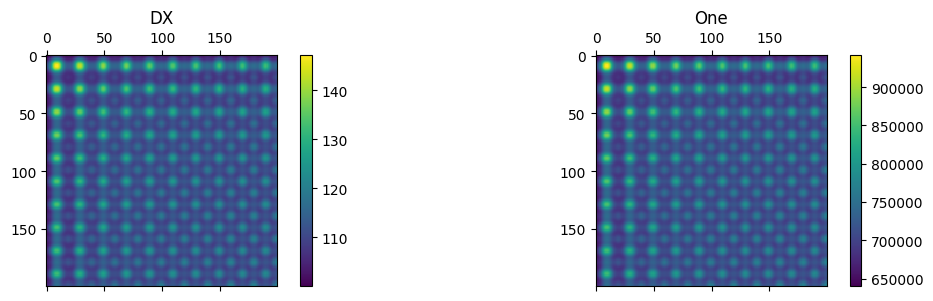

In [ ]:
f, ax = plt.subplots(figsize=(13, 3), ncols=2)
sx = ax[0].matshow(model_dx.K_fit)
s1 = ax[1].matshow(model_one.K_fit)


ax[0].set_title(f'DX')
ax[1].set_title(f'One')
f.colorbar(sx, ax = ax[0])
f.colorbar(s1, ax = ax[1])

## Test Four Roll

In [39]:
dx = 2*np.pi / 2**6
Re = 1
Wi = 4
beta = .9
X, Xmean = get_data(Re, Wi, beta, case='4roll', n_data = 5000,dir_path='../../npz_data', from_end=True)
theta =((1-beta)/(Re*Wi))
print('Theta: ', theta)

Theta:  0.024999999999999994


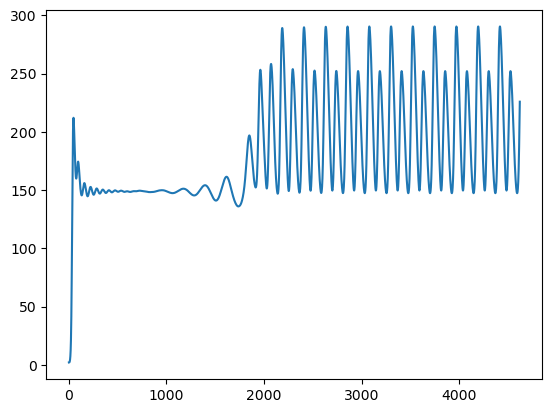

In [46]:
plt.plot(X[2::5][2048]**2 + X[4::5][2048]**2 + 2*X[3::5][2048]**2)

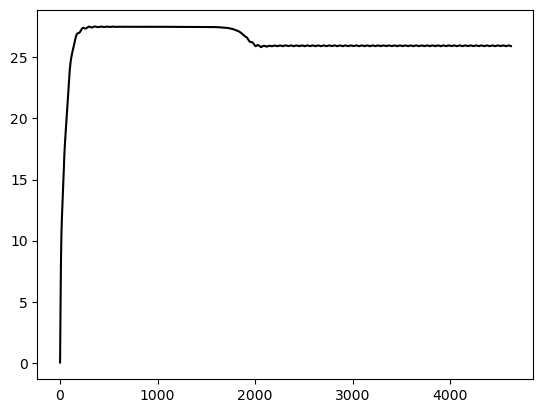

In [40]:
_,_, total = calc_energy(X, Wi, beta, Re, dx)
plt.plot(total,'k')

In [32]:
n_components = 3

model_base.fit(X.T,n_components,'oldroyd',theta = theta,dx=dx,center=False)
model_pca.fit(X.T,n_components,'linear',theta = theta,dx=dx,)
if not model_combo._is_fitted:
    model_combo.fit(X.T,n_components,'oldroyd',theta = theta,dx=dx,)

X_base = model_base.invert_transform(model_base.transform(X.T,theta, dx = dx), theta)
X_pca = model_pca.invert_transform(model_pca.transform(X.T,theta, 1), theta)

_,_, base = calc_energy(X_base, Wi, beta, Re, dx)
_,_, pca = calc_energy(X_pca, Wi, beta, Re, dx)

KeyboardInterrupt: 

In [8]:
kernel = 'rbf'
# gamma = (50, 2.5)
gamma =500
model_extra.fit(X.T,n_components,kernel,theta = theta,dx=dx,eps=gamma)

model_combo.K_fit = model_base.K_fit * model_extra.K_fit
model_combo.train_R(n_components=n_components, recalc_eig=True)

X_combo = reverse_combo(model_base, model_extra, model_combo, X.T, theta = theta, dx = dx, eps = gamma)
X_extra = model_extra.invert_transform(model_extra.transform(X.T,theta, eps = gamma, dx = dx), theta)


_,_, extra = calc_energy(X_extra, Wi, beta, Re, dx)
_,_, combo = calc_energy(X_combo, Wi, beta, Re, dx)

In [13]:
n_components = 10

model_base.train_R(n_components=n_components)
# model_pca.train_R(n_components=n_components)
# model_extra.train_R(n_components=n_components)
# model_combo.train_R(n_components=n_components)

X_base = model_base.invert_transform(model_base.normalized_eigenvector * model_base.eigenvalues[:model_base.n_components], theta)
X_base_transform = model_base.invert_transform(model_base.transform(X.T,theta, dx =dx), theta)
# X_pca = model_pca.invert_transform(model_pca.normalized_eigenvector * model_pca.eigenvalues[:model_pca.n_components], theta)
# X_combo = reverse_combo(model_base, model_extra, model_combo, X.T, theta = theta, dx = dx, eps = gamma)
# X_extra = model_extra.invert_transform(model_extra.transform(X.T,theta, eps = gamma, dx = dx), theta)

_,_, base = calc_energy(X_base, Wi, beta, Re, dx)
_,_, base_trans = calc_energy(X_base_transform, Wi, beta, Re, dx)
# _,_, pca = calc_energy(X_pca, Wi, beta, Re, dx)
# _,_, extra = calc_energy(X_extra, Wi, beta, Re, dx)
# _,_, combo = calc_energy(X_combo, Wi, beta, Re, dx)

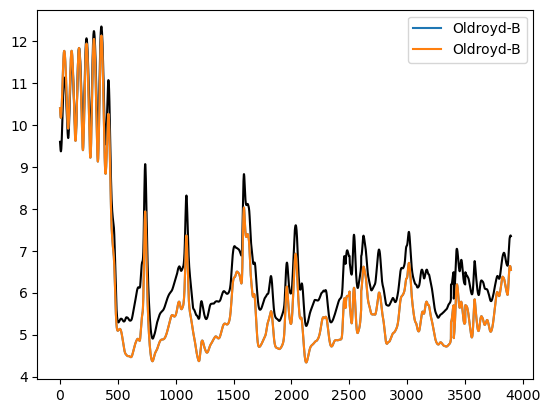

In [14]:

plt.plot(total,'k')
# plt.plot(pca, label = 'PCA')
# plt.plot(extra,'--', label = f'{kernel.capitalize()}')
plt.plot(base, label = 'Oldroyd-B')
plt.plot(base_trans, label = 'Oldroyd-B')
# plt.plot(combo,linestyle='dotted', label = f'Combo ({kernel})')

plt.legend()

In [197]:
err_oldroyd = np.abs(total - base).sum() / total.sum()
err_extra = np.abs(total - extra).sum() / total.sum()
err_pca = np.abs(total - pca).sum() / total.sum()
err_combo = np.abs(total - combo).sum() / total.sum()

print(f'Error Oldroyd: {err_oldroyd}')
print(f'Error {kernel.capitalize()}: {err_extra}')
print(f'Error PCA: {err_pca}')
print(f'Error Combo: {err_combo}')

Error Oldroyd: 0.011939647517762834
Error Rbf: 0.0077385371552081755
Error PCA: 0.013392587368556195
Error Combo: 0.00802320587347663


In [39]:
model_base.K_fit.mean(0).shape, np.mean(model_base.K_fit, axis=0).shape

((3899,), (3899,))

In [36]:
err_oldroyd = np.abs(total - base).sum() / total.sum()
err_extra = np.abs(total - extra).sum() / total.sum()
err_pca = np.abs(total - pca).sum() / total.sum()
err_combo = np.abs(total - combo).sum() / total.sum()

print(f'Error Oldroyd: {err_oldroyd}')
print(f'Error {kernel.capitalize()}: {err_extra}')
print(f'Error PCA: {err_pca}')
print(f'Error Combo: {err_combo}')

Error Oldroyd: 0.16592155012521592
Error Rbf: 0.21472936708356186
Error PCA: 0.17512569989796978
Error Combo: 0.23698998856026485


In [16]:
def err_nmodes(X, dx, Re, Wi, beta, nmodes,*models):
    errors = np.zeros((len(models), nmodes))
    theta =((1-beta)/(Re*Wi))
    _,_, total = calc_energy(X, Wi, beta, Re, dx)
    for ncomp in range(1,nmodes+1):
        print(f'{ncomp}...')
        for i,model in enumerate(models):
            model.train_R(n_components=ncomp)
            X_base = model.invert_transform(model.normalized_eigenvector * model.eigenvalues[:model_base.n_components], theta)
            _,_, base = calc_energy(X_base, Wi, beta, Re, dx)
            errors[i, ncomp-1] = np.abs(total - base).sum() / total.sum()
    return errors

In [17]:
errors = err_nmodes(X, dx, Re, Wi, beta, 20, model_base, model_pca)

1...
2...
3...
4...
5...
6...
7...
8...
9...
10...
11...
12...
13...
14...
15...
16...
17...
18...
19...
20...


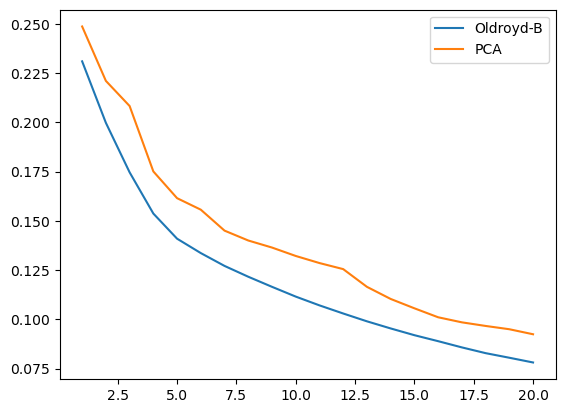

In [18]:
plt.plot(np.arange(20) + 1,errors[0], label='Oldroyd-B')
plt.plot(np.arange(20) + 1,errors[1], label='PCA')
plt.legend()